In [22]:
!pip install Lifetimes
!pip install squarify

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from pandas_profiling import ProfileReport
import datetime as dt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
import squarify

# Data Preperation

In [2]:
data = pd.read_excel("Dataset.xlsx")

In [3]:
data['InvoiceDate'].agg(['min', 'max'])

min   2009-12-01 07:45:00
max   2010-12-09 20:01:00
Name: InvoiceDate, dtype: datetime64[ns]

In [4]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
fd = data.drop_duplicates()
fd = fd [['Customer ID','Description','InvoiceDate','Invoice','Quantity','Price', 'Country']]
fd = fd[(fd['Quantity']>0)]
fd['TotalPurchase'] = fd['Quantity'] * fd['Price']

In [ ]:
df.Country.value_counts()[:10].plot(kind='bar')

In [6]:
new = summary_data_from_transaction_data(fd, 'Customer ID', 'InvoiceDate', monetary_value_col='TotalPurchase', observation_period_end='2011-12-9')
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


count    4314.00000
mean        2.94089
std         6.01875
min         0.00000
25%         0.00000
50%         1.00000
75%         3.00000
max       127.00000
Name: frequency, dtype: float64
0.002847023851437119


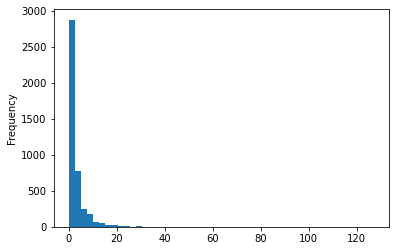

In [7]:
new['frequency'].plot(kind='hist', bins=50)
print(new['frequency'].describe())
print(sum(new['frequency'] == 0)/float(len(data)))

In [8]:
fdg = fd.groupby(['Customer ID','Country']).agg({'InvoiceDate': lambda date: (date.max() - date.min()).days,
                                                 'Quantity': lambda quant: quant.sum(),
                                                 'Invoice': lambda num: len(num),
                                                 'TotalPurchase': lambda price: price.sum()    })

In [9]:
fdg.columns=['num_days','num_transactions','num_units','spent_money']
fdg['avg_order_value'] = fdg['spent_money']/fdg['num_transactions']
purchase_frequency = sum(fdg['num_transactions'])/fdg.shape[0]
repeat_rate = round(fdg[fdg.num_transactions > 1].shape[0]/fdg.shape[0],2)
churn_rate = round(1-repeat_rate,2)

In [10]:
fdg.reset_index()

,Customer ID,Country,num_days,num_transactions,num_units,spent_money,avg_order_value
0,12346.0,United Kingdom,196,70,33,372.86,5.326571
1,12347.0,Iceland,37,828,71,1323.32,1.598213
2,12348.0,Finland,0,373,20,222.16,0.595603
3,12349.0,Italy,181,993,102,2671.14,2.689970
4,12351.0,Unspecified,0,261,21,300.93,1.152989
...,...,...,...,...,...,...,...
4314,18283.0,United Kingdom,275,322,217,619.37,1.923509
4315,18284.0,United Kingdom,0,494,28,461.68,0.934575
4316,18285.0,United Kingdom,0,145,12,427.00,2.944828
4317,18286.0,United Kingdom,247,608,67,1296.43,2.132286


In [11]:
fdg['profit_margin'] = fdg['spent_money']*0.05
fdg['CLV'] = (fdg['avg_order_value']*purchase_frequency)/churn_rate
fdg.reset_index(inplace = True)
fdg['spent_money', 'avg_order_value','profit_margin'] = fdg.spent_money.apply(lambda x : "{:,}".format(x))
data.dropna(inplace=True)
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data["InvoiceDate"].max()
today_date = dt.datetime(2011, 12, 11)
data["TotalPrice"] = data["Price"] * data["Quantity"]

In [51]:
np.log(fdg.CLV).describe()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


count    4319.000000
mean            -inf
std              NaN
min             -inf
25%        12.129924
50%        12.383046
75%        12.646861
max        21.059775
Name: CLV, dtype: float64

In [12]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [13]:
rfm = data.groupby("Customer ID").agg({"InvoiceDate": lambda InvıiceDate: (today_date- InvıiceDate.max()).days,
                                       "Invoice": lambda Invoice: Invoice.nunique(),
                                       "TotalPrice": lambda TotalPrice: TotalPrice.sum()})
rfm.columns = ["recency","frequency","monetary"]
rfm = rfm[rfm["monetary"] > 0]
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4282.0,453.560953,95.734145,3.660000e+02,382.0000,415.00,495.0000,739.00
frequency,4282.0,5.455395,10.148765,1.000000e+00,1.0000,3.00,6.0000,270.00
monetary,4282.0,1971.709950,8596.562848,1.776357e-15,303.6925,686.65,1683.9625,341776.73


In [14]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["monetary_score"] = pd.qcut(rfm["monetary"], 5, labels=[1, 2, 3, 4, 5])
rfm["RFM_SCORE"] = (rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str))

In [15]:
seg_map = {
    r'[1-2][1-2]': 'HIBERNATING',
    r'[1-2][3-4]': 'AT RISK',
    r'[1-2]5': 'CANT LOSE',
    r'3[1-2]': 'ABOUT TO SLEEP',
    r'33': 'NEED ATTENTION',
    r'[3-4][4-5]': 'LOYAL CUSTOMER',
    r'41': 'PROMISING',
    r'51': 'NEW CUSTOMERS',
    r'[4-5][2-3]': 'POTENTIAL LOYALIST',
    r'5[4-5]': 'CHAMPIONS'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
Customer ID,,,,,,,,
12347.0,368,2,1323.32,5,2,4,52,POTENTIAL LOYALIST
12348.0,439,1,222.16,2,1,1,21,HIBERNATING
12349.0,408,4,2646.99,3,3,5,33,NEED ATTENTION
12351.0,376,1,300.93,5,1,2,51,NEW CUSTOMERS
12352.0,376,2,343.80,5,2,2,52,POTENTIAL LOYALIST
12353.0,409,1,317.76,3,1,2,31,ABOUT TO SLEEP
12355.0,568,1,488.21,1,1,2,11,HIBERNATING
12356.0,381,3,3562.25,4,3,5,43,POTENTIAL LOYALIST
12357.0,389,2,12079.99,4,2,5,42,POTENTIAL LOYALIST


In [16]:
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])

recency        frequency           monetary      
                          mean count       mean count         mean count
segment                                                                 
ABOUT TO SLEEP      416.171171   333   1.360360   333   461.130330   333
AT RISK             514.787829   608   3.677632   608  1009.869278   608
CANT LOSE           487.717391    92  11.043478    92  3511.697174    92
CHAMPIONS           370.988710   620  16.003226   620  6801.576440   620
HIBERNATING         572.638806  1005   1.232836  1005   380.881676  1005
LOYAL CUSTOMER      399.157552   768   8.548177   768  2779.925514   768
NEED ATTENTION      415.170213   188   2.909574   188   985.763245   188
NEW CUSTOMERS       372.702128    47   1.000000    47   352.439787    47
POTENTIAL LOYALIST  382.389414   529   2.349716   529   727.982762   529
PROMISING           388.923913    92   1.000000    92   331.430761    92

In [17]:
#!pip install pyecharts

In [18]:
from pyecharts.charts import Pie
from pyecharts import options as opts
sgm= rfm["segment"].value_counts()
c = sgm.index.tolist()
d = sgm.tolist()
color_series = ['#5b9aa0','#667292','#8d9db6','#daebe8','#d6d4e0',
 '#e4d1d1','#b0aac0','#f9d5e5','#b9b0b0','#622569']
rosechart = Pie(init_opts=opts.InitOpts(width='1350px', height='750px'))
rosechart.set_colors(color_series)
rosechart.add("", [list(z) for z in zip(c, d)],
        radius=["20%", "95%"], 
        center=["30%", "60%"],
        rosetype="area")
rosechart.set_global_opts(title_opts=opts.TitleOpts(title='CLV',subtitle="Customer Segmentation"),
                     legend_opts=opts.LegendOpts(is_show=False),
                     toolbox_opts=opts.ToolboxOpts())
rosechart.set_series_opts(label_opts=opts.LabelOpts(is_show=True, position="inside", font_size=12,formatter="{b}:{c}", font_style="italic",font_weight="bold", font_family="Century"),)
rosechart.render_notebook()
        



In [19]:
DFT = rfm.groupby('segment').agg('count').reset_index()
DFT.head()

,segment,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,ABOUT TO SLEEP,333,333,333,333,333,333,333
1,AT RISK,608,608,608,608,608,608,608
2,CANT LOSE,92,92,92,92,92,92,92
3,CHAMPIONS,620,620,620,620,620,620,620
4,HIBERNATING,1005,1005,1005,1005,1005,1005,1005


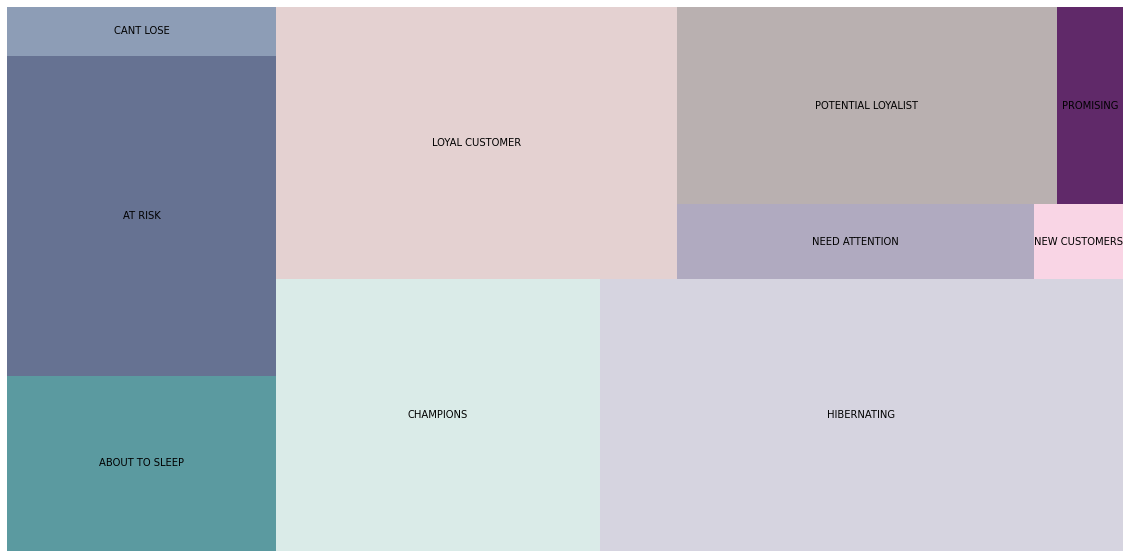

In [23]:
df_treemap = rfm.groupby('segment').agg('count').reset_index()
fig, ax = plt.subplots(1, figsize = (20,10))
squarify.plot(sizes=df_treemap['RFM_SCORE'], 
              label=df_treemap['segment'], 
              color=['#5b9aa0','#667292','#8d9db6','#daebe8','#d6d4e0',
                     '#e4d1d1','#b0aac0','#f9d5e5','#b9b0b0','#602969'])
plt.axis('off')
plt.show()

# Model

In [24]:
#BG/NBD Model 
cltv_df = data.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days,
                                                           lambda date: (today_date - date.min()).days],
                                           'Invoice':      lambda num: num.nunique(),
                                           'TotalPrice':   lambda TotalPrice: TotalPrice.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
cltv_df = cltv_df[cltv_df["monetary"] > 0]
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [25]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

In [26]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12347.0,5.285714,57.857143,2,661.660000
12349.0,46.714286,105.142857,4,661.747500
12352.0,2.285714,56.142857,2,171.900000
12356.0,6.285714,60.714286,3,1187.416667
12357.0,0.000000,55.571429,2,6039.995000


In [28]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 3080 subjects, a: 5.63, alpha: 6.54, b: 28.51, r: 1.96>

/opt/anaconda3/lib/python3.8/site-packages/lifetimes/fitters/beta_geo_fitter.py:256: RuntimeWarning: overflow encountered in double_scalars
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

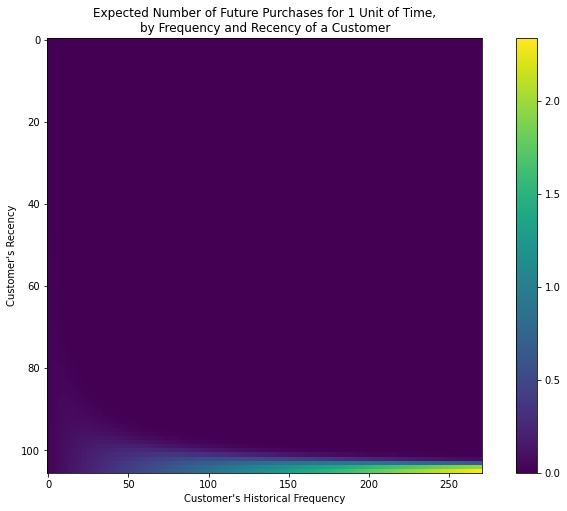

In [29]:
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

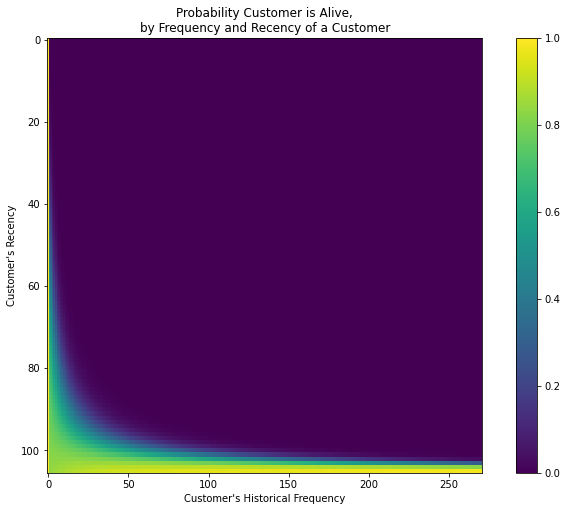

In [30]:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [31]:
summary_cal_holdout = calibration_and_holdout_data(fd, 'Customer ID', 'InvoiceDate',
                                        calibration_period_end='2010-11-09',
                                        observation_period_end='2011-01-01' )   
print(summary_cal_holdout.head())

             frequency_cal  recency_cal  T_cal  frequency_holdout  \
Customer ID                                                         
12346.0                6.0        196.0  330.0                0.0   
12347.0                0.0          0.0    9.0                1.0   
12348.0                0.0          0.0   43.0                0.0   
12349.0                2.0        182.0  194.0                0.0   
12353.0                0.0          0.0   13.0                0.0   

             duration_holdout  
Customer ID                    
12346.0                  53.0  
12347.0                  53.0  
12348.0                  53.0  
12349.0                  53.0  
12353.0                  53.0  


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

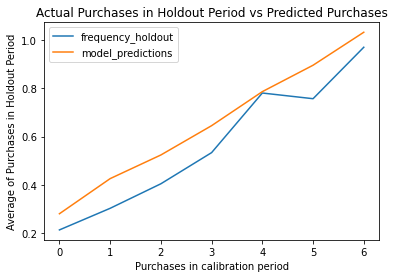

In [32]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [33]:
cltv_df["expected_purc_1_week"] = bgf.predict(1,cltv_df['frequency'],cltv_df['recency'],cltv_df['T'])
cltv_df["expected_purc_1_month"] = bgf.predict(4,cltv_df['frequency'],cltv_df['recency'],cltv_df['T'])
cltv_df.sort_values("expected_purc_1_week", ascending=False)
cltv_df.sort_values("expected_purc_1_month", ascending=False)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
15329.0,51.428571,103.714286,16,108.592500,7.721015e-02,3.088111e-01
14030.0,53.142857,105.571429,16,361.593750,7.712280e-02,3.084620e-01
15694.0,52.285714,104.714286,16,258.928750,7.705021e-02,3.081716e-01
16858.0,51.142857,103.571429,16,255.358750,7.692939e-02,3.076881e-01
12839.0,52.142857,104.714286,16,271.513125,7.679260e-02,3.071412e-01
...,...,...,...,...,...,...
14156.0,52.285714,105.571429,138,1327.395290,3.414016e-18,1.365256e-17
15311.0,53.285714,105.571429,158,342.365380,1.408824e-20,5.633803e-20
12748.0,52.714286,105.142857,159,131.434151,7.292359e-21,2.916168e-20


In [34]:
#Gamma model
ggf = GammaGammaFitter(penalizer_coef=0.1)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 3080 subjects, p: 0.67, q: 0.17, v: 0.91>

In [35]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],cltv_df['monetary'])
cltv_df.sort_values("expected_average_profit", ascending=False)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit
Customer ID,,,,,,,
12357.0,0.000000,55.571429,2,6.039995e+03,0.021796,0.087180,15880.744925
14091.0,6.285714,99.857143,2,4.765040e+03,0.016242,0.064964,12528.802785
17450.0,10.000000,62.714286,8,5.762152e+03,0.060922,0.243670,6818.517245
17308.0,8.428571,64.714286,2,2.255880e+03,0.020385,0.081536,5932.052987
16749.0,18.857143,103.571429,2,2.193540e+03,0.015940,0.063757,5768.156949
...,...,...,...,...,...,...,...
12768.0,2.714286,64.428571,2,1.065814e-14,0.020410,0.081638,1.193283
13703.0,0.142857,59.428571,2,7.105427e-15,0.021167,0.084663,1.193283
14598.0,0.000000,81.428571,2,1.776357e-15,0.018158,0.072632,1.193283


In [36]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=6, 
                                   freq="W",
                                   discount_rate=0.01)

In [37]:
cltv = cltv.reset_index()
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
2661,17450.0,10.000000,62.714286,8,5762.152500,0.060922,0.243670,6818.517245,10453.628351
4,12357.0,0.000000,55.571429,2,6039.995000,0.021796,0.087180,15880.744925,8713.550874
881,14091.0,6.285714,99.857143,2,4765.040000,0.016242,0.064964,12528.802785,5122.929287
2921,17940.0,41.571429,105.285714,8,3122.055000,0.047373,0.189481,3694.477080,4405.042046
31,12415.0,21.714286,75.428571,7,2791.977143,0.050878,0.203498,3392.757665,4344.382818
780,13902.0,14.000000,104.571429,8,3801.407500,0.036066,0.144253,4498.358185,4083.300343
3061,18251.0,38.857143,102.571429,8,2745.517500,0.047970,0.191870,3248.918432,3922.599909
1793,15838.0,51.000000,103.571429,19,2108.071053,0.068563,0.274222,2255.215099,3890.244350
2630,17381.0,25.571429,78.428571,12,1643.896667,0.072322,0.289262,1833.302652,3336.240740
880,14088.0,4.714286,60.285714,6,1997.421667,0.049146,0.196570,2517.565055,3113.943949


In [38]:
# 1 Month CLTV:
cltv_1 = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=1,  # 1 month
                                   freq="W",  # frequency of T
                                   discount_rate=0.01)
cltv_1= cltv_1.reset_index()
cltv_1 = cltv_df.merge(cltv_1, on="Customer ID", how="left")
cltv_1.sort_values(by="clv", ascending=False).head(5)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
2661,17450.0,10.000000,62.714286,8,5762.152500,0.060922,0.243670,6818.517245,1786.883885
4,12357.0,0.000000,55.571429,2,6039.995000,0.021796,0.087180,15880.744925,1489.005027
881,14091.0,6.285714,99.857143,2,4765.040000,0.016242,0.064964,12528.802785,875.369413
2921,17940.0,41.571429,105.285714,8,3122.055000,0.047373,0.189481,3694.477080,752.876078
31,12415.0,21.714286,75.428571,7,2791.977143,0.050878,0.203498,3392.757665,742.538316


In [39]:
cltv_12 = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=12, 
                                   freq="W",  
                                   discount_rate=0.01)
cltv_12 = cltv_12.reset_index()
cltv_12 = cltv_df.merge(cltv_12, on="Customer ID", how="left")
cltv_12.sort_values(by="clv", ascending=False).head(5)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
2661,17450.0,10.000000,62.714286,8,5762.152500,0.060922,0.243670,6818.517245,20288.493700
4,12357.0,0.000000,55.571429,2,6039.995000,0.021796,0.087180,15880.744925,16917.049897
881,14091.0,6.285714,99.857143,2,4765.040000,0.016242,0.064964,12528.802785,9946.725791
2921,17940.0,41.571429,105.285714,8,3122.055000,0.047373,0.189481,3694.477080,8550.592115
31,12415.0,21.714286,75.428571,7,2791.977143,0.050878,0.203498,3392.757665,8432.464256


# Linear Regression model

In [ ]:
data = pd.read_excel("Dataset.xlsx")

In [73]:
uk_data=data[data.Country=='United Kingdom']
uk_data['TotalPurchase'] = uk_data['Quantity'] * uk_data['Price']
uk_data['month_yr'] = uk_data['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))
sale=uk_data.pivot_table(index=['Customer ID'],columns=['month_yr'],values='TotalPurchase',aggfunc='sum',fill_value=0).reset_index()
sale['CLV']=sale.iloc[:,2:].sum(axis=1)

In [74]:
sale.head()

month_yr,Customer ID,Apr-2010,Aug-2010,Dec-2009,Dec-2010,Feb-2010,Jan-2010,Jul-2010,Jun-2010,Mar-2010,May-2010,Nov-2010,Oct-2010,Sep-2010,CLV
0,12346.0,0.00,0.00,113.5,0.00,0.00,-13.5,0.0,-186.23,27.05,0.00,0.00,-5.50,0.0,-64.68
1,12608.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,415.79,0.0,415.79
2,12745.0,0.00,266.93,0.0,0.00,0.00,0.0,0.0,0.00,0.00,456.92,0.00,0.00,0.0,723.85
3,12746.0,0.00,0.00,-11.9,0.00,0.00,0.0,0.0,242.75,0.00,0.00,0.00,0.00,0.0,230.85
4,12747.0,190.43,629.68,1000.2,358.56,236.35,0.0,0.0,646.75,202.64,267.37,388.85,1047.75,0.0,4778.15


In [81]:
#!pip install sklearn
from sklearn.model_selection import train_test_split

In [96]:

X=sale[['Dec-2010','Nov-2010', 'Oct-2010','Sep-2010','Aug-2010','Jul-2010']]
y=sale[['CLV']]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)


In [97]:
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

In [98]:
print(linreg.intercept_)
print(linreg.coef_)

[82.64948199]
[[1.44451195 1.79020402 1.32967484 1.35736593 2.21193575 2.22726085]]


In [99]:
from sklearn import metrics
y_pred_score = linreg.score(X_test, y_test)
print("Prediction score is: {}".format(y_pred_score))

Prediction score is: 0.865548684763809


In [100]:
# calculate MAE using scikit-learn
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))
#calculate mean squared error
print("MSE",metrics.mean_squared_error(y_test, y_pred))
# compute the RMSE of our predictions
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 582.0151979354841
MSE 2263410.966120404
RMSE: 1504.463680558758


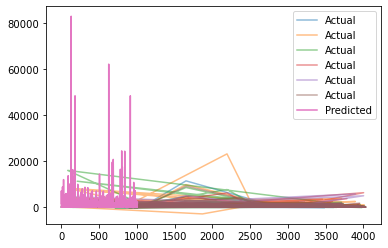

In [113]:
from matplotlib import pyplot
pyplot.plot(X_test, label='Actual',alpha=0.5 )
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()